In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import os
import json
from typing import Dict, List, Optional, Union, cast
import requests

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

from env import github_token, github_username
import acquire, prep, model

In [2]:
# plotting defaults

plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

## Acquire FreeCodeCamp README Dataset

In [3]:
# Load the data from json file
df = pd.read_json('data.json') # dataframe containing original 105 readmes
df1 = pd.read_json('test_data.json') # dataframe containing extra 36 readmes

# Print the shape of the df
df.shape, df1.shape

((105, 3), (36, 3))

In [4]:
# Take a peek at the train/validate dataset
df.head(2)

,repo,language,readme_contents
0,freeCodeCamp/chapter,TypeScript,# Welcome to Chapter\n[![All Contributors](htt...
1,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...


In [5]:
# Take a peek at the test dataset
df1.head(2)

,repo,language,readme_contents
0,freeCodeCamp/privacy-policy,CSS,> ### This page is now archived and managed in...
1,freeCodeCamp/code-of-conduct,CSS,> ### This page is now archived and managed in...


In [6]:
# Merge the two dataframe together
df = pd.concat([df, df1], axis=0, ignore_index=True)

# Print the shape
print(df.shape)

# Take a peek at the df
df.head()

(141, 3)


,repo,language,readme_contents
0,freeCodeCamp/chapter,TypeScript,# Welcome to Chapter\n[![All Contributors](htt...
1,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
2,freeCodeCamp/nginx-config,None,# nginx-config\n\nConfig for our NGINX instanc...
3,freeCodeCamp/chat-config,HTML,Usage:\n\n1. Create a .env\n\n ```txt\n RO...
4,freeCodeCamp/devdocs,Ruby,# [DevDocs](https://devdocs.io) — API Document...


In [7]:
# Quick summarize df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             141 non-null    object
 1   language         133 non-null    object
 2   readme_contents  132 non-null    object
dtypes: object(3)
memory usage: 3.4+ KB


**Takeaways**
- Missing values are found in the columns 'language' and 'readme_contents'.
- We decide to drop the records with missing values. 

## Wrangle README Datasets

In [8]:
# Drop the missing values
df = df.dropna()

# Print the shape of the df
df.shape

(125, 3)

In [9]:
# Clean the text by helper function
# Exlude words: 'freecodecamp', 'repository', 'run', 'test', 'use', 'using'

df = prep.prep_data(df, 'readme_contents', 
                    extra_words=['freecodecamp', 'repository', 'run', 'test', 'use', 'using'],
                    exclude_words=[])
# Print the shape
df.shape

(125, 6)

In [10]:
# Quick summarize dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 140
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             125 non-null    object
 1   language         125 non-null    object
 2   readme_contents  125 non-null    object
 3   stemmed          125 non-null    object
 4   lemmatized       125 non-null    object
 5   clean            125 non-null    object
dtypes: object(6)
memory usage: 6.8+ KB


## Quick Exploration
- Detailed Exploration could be find in the autin_scratch.ipynb

In [14]:
# Compute the relative frequency in each language in train/validate
pd.concat([df.language.value_counts(), 
           df.language.value_counts(normalize=True)], axis=1)

,language,language
JavaScript,74,0.592
Python,14,0.112
HTML,13,0.104
CSS,12,0.096
Shell,3,0.024
TypeScript,3,0.024
Ruby,2,0.016
R,2,0.016
SCSS,1,0.008
Handlebars,1,0.008


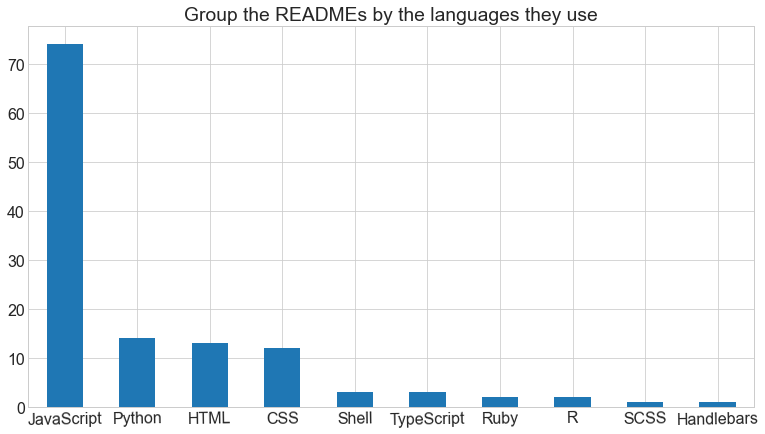

In [13]:
# Viz the distribution of the languages in train/validate

df.language.value_counts().plot(kind='bar', rot=1)
plt.title('Group the READMEs by the languages they use')
plt.show()

**Takeaways**
- Nearly 60% of the languages written in test are JavaScript. 
- We decide to perform a binary classification: to predict the languages that the repo uses is JavaScript or not. 

## Additional Wrangling

In [15]:
# Convert languages into js or not
df.language = df.language.apply(lambda i: 'js' if i == 'JavaScript' else 'other')

In [16]:
# Take a peek at the df
df.head(2)

,repo,language,readme_contents,stemmed,lemmatized,clean
0,freeCodeCamp/chapter,other,# Welcome to Chapter\n[![All Contributors](htt...,welcom to chapter all contributorshttpsimgshie...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...
1,freeCodeCamp/freeCodeCamp,js,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...


In [17]:
# Add column words
df['words'] = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc)\
               .split() for doc in df.lemmatized]

In [18]:
# Drop the column repo
df.drop(columns = ['repo', 'stemmed'], inplace=True)

In [19]:
# Rename the columns
df.columns = ['label', 'text', 'lemmatized', 'clean', 'words']

In [20]:
# Take a peek at the df1
df.head(2)

,label,text,lemmatized,clean,words
0,other,# Welcome to Chapter\n[![All Contributors](htt...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...,"[welcome, to, chapter, all, contributorshttpsi..."
1,js,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,"[freecodecamporg, social, bannerhttpss3amazona..."


## Modeling
### Goal: to predict the language used for the repo is JavaScript or not (binary classification).

In [23]:
# Split df into train and validate and create the test dataset

train_validate, test = train_test_split(df[['label', 'clean']], 
                                        stratify=df.label, 
                                        test_size=.1,
                                        random_state=123)

train, validate = train_test_split(train_validate[['label', 'clean']], 
                                   stratify=train_validate.label, 
                                   test_size=.1,
                                   random_state=123)

In [22]:
# Print the 

print(train.label.value_counts())
print(validate.label.value_counts())
print(test.label.value_counts())
train.head()

js       59
other    41
Name: label, dtype: int64
js       7
other    5
Name: label, dtype: int64
js       8
other    5
Name: label, dtype: int64


,label,clean
30,js,sudoku solverhttpswwwfreecodecamporglearnquali...
72,js,mongodbstatsd fetch metric multiple mongodb se...
53,other,assignment create port scanner python port_sca...
13,js,ghost configs redirects routing
54,other,assignment challenge create program play rock ...


#### Compute the baseline accuracy

In [24]:
labels = pd.concat([train.label.value_counts(), # get total counts of js vs other
                    train.label.value_counts(normalize=True)], axis=1) # getting the prop of js vs other
labels.columns = ['n', 'percent']
labels

,n,percent
js,59,0.59
other,41,0.41


**Takeaway**:
- The baseline accuracy is 59%. 

### Feature Generation: Bag of Words

In [25]:
# Create CountVectorizer, which create bag-of-words model.
# stop_words : Specify language to remove stopwords. 
# min_df: ignore terms that have a document frequency strictly 
# lower than the given threshold. This value is also called cut-off in the literature. 
# If float, the parameter represents a proportion of documents, integer absolute counts. 
# ngram_range: the lower and upper boundary of the range of n-values for 
# different word n-grams or char n-grams to be extracted. 

vectorizer = CountVectorizer(stop_words='english', 
                             min_df=15, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer.fit(train.clean)

# Get dictionary. 
vectorizer.get_feature_names()

['add',
 'api',
 'app',
 'application',
 'automatically',
 'build',
 'change',
 'check',
 'clone',
 'code',
 'contributing',
 'copy',
 'create',
 'data',
 'development',
 'directory',
 'environment',
 'example',
 'file',
 'follow',
 'following',
 'function',
 'git',
 'github',
 'help',
 'install',
 'instruction',
 'issue',
 'key',
 'license',
 'like',
 'list',
 'local',
 'make',
 'make sure',
 'message',
 'need',
 'new',
 'note',
 'npm',
 'npm install',
 'number',
 'open',
 'page',
 'project',
 'pull',
 'request',
 'running',
 'server',
 'set',
 'source',
 'start',
 'string',
 'submit',
 'sure',
 'test',
 'testing',
 'time',
 'unit',
 'url',
 'user',
 'want',
 'work']

In [26]:
# Transform each sentences in vector space

X_train_bow = vectorizer.transform(train.clean)
X_validate_bow = vectorizer.transform(validate.clean)
X_test_bow = vectorizer.transform(test.clean)

In [27]:
# this is just to see the array of 0's and 1's

X_train_bowarray = X_train_bow.toarray()
X_validate_bowarray = X_validate_bow.toarray()
X_test_bowarray = X_test_bow.toarray()
X_train_bowarray[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
# # Show sentences and vector space representation.
# # purely to visualize what's happening.
# for i, v in zip(train.clean, bow_array):
#     print(i)
#     print(v)

### Feature Generation: TF-IDF

In [29]:
# Transform the clean text into sparse matrix

tfidf = TfidfVectorizer(stop_words='english', min_df=15, 
                        ngram_range=(1,2), 
                        binary=True)

# Fit on cleaned text in train
tfidf = tfidf.fit(train.clean)

# Get vocabularies.
tfidf.vocabulary_

{'server': 48,
 'set': 49,
 'create': 12,
 'file': 18,
 'function': 21,
 'url': 59,
 'list': 31,
 'number': 41,
 'check': 7,
 'example': 17,
 'open': 42,
 'string': 52,
 'like': 30,
 'following': 20,
 'make': 33,
 'sure': 54,
 'new': 37,
 'development': 14,
 'code': 9,
 'testing': 56,
 'unit': 58,
 'test': 55,
 'project': 44,
 'automatically': 4,
 'copy': 11,
 'submit': 53,
 'make sure': 34,
 'time': 57,
 'need': 36,
 'want': 61,
 'change': 6,
 'message': 35,
 'api': 1,
 'build': 5,
 'follow': 19,
 'start': 51,
 'work': 62,
 'app': 2,
 'git': 22,
 'clone': 8,
 'install': 25,
 'request': 46,
 'running': 47,
 'note': 38,
 'pull': 45,
 'user': 60,
 'source': 50,
 'application': 3,
 'local': 32,
 'page': 43,
 'data': 13,
 'help': 24,
 'instruction': 26,
 'contributing': 10,
 'add': 0,
 'github': 23,
 'license': 29,
 'key': 28,
 'npm': 39,
 'environment': 16,
 'issue': 27,
 'npm install': 40,
 'directory': 15}

In [30]:
# Transform the train and validate

X_train_tfidf = tfidf.transform(train.clean)
X_validate_tfidf = tfidf.transform(validate.clean)
X_test_tfidf = tfidf.transform(test.clean)

# Take a peek at 
X_train_tfidf

<100x63 sparse matrix of type '<class 'numpy.float64'>'
	with 1381 stored elements in Compressed Sparse Row format>

In [31]:
# Conver to datafame
pd.DataFrame(X_train_tfidf.todense(), columns=tfidf.get_feature_names()).head()

,add,api,app,application,automatically,build,change,check,clone,code,...,submit,sure,test,testing,time,unit,url,user,want,work
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.203679,0.0,0.000000,0.200092,0.0,0.187153,...,0.215509,0.215509,0.178651,0.207433,0.000000,0.229377,0.190199,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.217213,0.0,0.244618,0.000000,0.0,0.199590,...,0.229830,0.000000,0.190523,0.221217,0.213388,0.244618,0.202837,0.0,0.225415,0.0


In [32]:
# Transform to document-term matrix

X_train_tfidfarray = X_train_tfidf.toarray()
X_validate_tfidfarray = X_validate_tfidf.toarray()
X_test_tfidfarray = X_test_tfidf.toarray()

In [33]:
# # Show sentences and vector space representation.
# # 
# # (A, B) C
# # A : Document Index
# # B : Specific word-vector index
# # C : TF-IDF score
# for i, v in zip(train.clean, vector_spaces):
#     print(i)
#     print(v)

### Model on Train using LogisticRegression

In [34]:
# create our y datasets

y_train = train['label']
y_validate = validate['label']
y_test = test['label']

#### Using bow features

In [35]:
# Create the LogisticRegressioin object and fit on train
lm = LogisticRegression().fit(X_train_bow, y_train)

# Predict the labels for the train
y_pred = lm.predict(X_train_bow)

In [36]:
# Compute the confusion matrix
confusion_matrix(train.label, y_pred)

array([[55,  4],
       [12, 29]])

In [37]:
# Compute the performance metrics
print(classification_report(train.label, y_pred))

              precision    recall  f1-score   support

          js       0.82      0.93      0.87        59
       other       0.88      0.71      0.78        41

    accuracy                           0.84       100
   macro avg       0.85      0.82      0.83       100
weighted avg       0.84      0.84      0.84       100



**Takeaways**
- when min_df = 20: 
    - The accuracy is 67%, which beats the baseline 
    - The lm performs better on predicting the JavaScript than other language.
- when min_df = 15:
    - The accuracy is 81%, which get improved by 84%. 

#### Model TFIDF

In [38]:
# Fit the LogisticRegression on TFIDF features
lm_tfidf = LogisticRegression().fit(X_train_tfidf, y_train)

# Predic the labels
y_pred = lm_tfidf.predict(X_train_tfidf)

In [39]:
# Compute the confusion matrix
confusion_matrix(train.label, y_pred)

array([[56,  3],
       [20, 21]])

In [40]:
# Compute the performance metrics
print(classification_report(train.label, y_pred))

              precision    recall  f1-score   support

          js       0.74      0.95      0.83        59
       other       0.88      0.51      0.65        41

    accuracy                           0.77       100
   macro avg       0.81      0.73      0.74       100
weighted avg       0.79      0.77      0.75       100



**Takeaways**
- When min_df = 20
    - The accuracy is 0.64, which also beats the baseline.
    - Simiar to bow features, the lm performs better on predicting the JavaScript than other language.
- When min_df = 15
    - The accuracy is 0.77, which get improved by 12%. 

### Model on Validate

In [41]:
# Predict the labels basded on both features. 

y_pred_bow = lm.predict(X_validate_bow)
y_pred_tfidf = lm_tfidf.predict(X_validate_tfidf)

In [42]:
# Compute the performance metrics for bow features. 
print(classification_report(validate.label, y_pred_bow))

              precision    recall  f1-score   support

          js       0.86      0.86      0.86         7
       other       0.80      0.80      0.80         5

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12



In [43]:
# Compute the performance metrics for tfidf features.
print(classification_report(validate.label, y_pred_tfidf))

              precision    recall  f1-score   support

          js       0.55      0.86      0.67         7
       other       0.00      0.00      0.00         5

    accuracy                           0.50        12
   macro avg       0.27      0.43      0.33        12
weighted avg       0.32      0.50      0.39        12



**Takeaways**
- The accuracy drops back to 50% for tfidf features features, which is below the baseline. Obviously overfitting issue exits.
- However, the accuracy is still consistent with bow features, which is 83%.

### Model on Test

In [44]:
# Predict the labels basded on both features. 

y_pred_bow = lm.predict(X_test_bow)
y_pred_tfidf = lm_tfidf.predict(X_test_tfidf)

In [45]:
# Compute the performance metrics for bow features. 
print(classification_report(test.label, y_pred_bow))

              precision    recall  f1-score   support

          js       0.75      0.75      0.75         8
       other       0.60      0.60      0.60         5

    accuracy                           0.69        13
   macro avg       0.68      0.68      0.68        13
weighted avg       0.69      0.69      0.69        13



In [46]:
# Compute the performance metrics for tfidf features.
print(classification_report(test.label, y_pred_tfidf))

              precision    recall  f1-score   support

          js       0.75      0.75      0.75         8
       other       0.60      0.60      0.60         5

    accuracy                           0.69        13
   macro avg       0.68      0.68      0.68        13
weighted avg       0.69      0.69      0.69        13



**Takeaways**
- The accuracy on test datasets are 69% for both bow and tfidf features. 

**Future Works**:
1. To enlarge the dataset.
2. Try different classification algorithms.
3. To exclude the 'run', 'repository' and similar words to reduce the noise. 

### How does the min_df affect the model performance?

In [47]:
# Loop through 

metrics_min_df = []
lr = LogisticRegression()

for i in range (5, 21):
    vectorizer = CountVectorizer(stop_words='english', 
                                 min_df=i, 
                                 ngram_range=(1,2), 
                                 binary=True)
    vectorizer = vectorizer.fit(train.clean)
    X_train = vectorizer.transform(train.clean)
    X_validate = vectorizer.transform(validate.clean)
    lr = lr.fit(X_train, y_train)
    y_pred_train = lr.predict(X_train)
    y_pred_validate = lr.predict(X_validate)
    d1 = model.estimator_report(i, 'train', train.label, y_pred_train)
    metrics_min_df.append(d1)
    d2 = model.estimator_report(i, 'validate', validate.label, y_pred_validate)
    metrics_min_df.append(d2)

In [48]:
# Conver the metrics into dataframe
metrics_min_df = pd.DataFrame(metrics_min_df)

# Rename the columns
metrics_min_df.rename(columns={'model_type':'min_df'}, inplace=True)
metrics_min_df.head()

,min_df,data_type,accuracy,precision,recall
0,5,train,0.980000,0.953488,1.0
1,5,validate,0.583333,0.500000,0.6
2,6,train,0.970000,0.931818,1.0
3,6,validate,0.666667,0.571429,0.8
4,7,train,0.970000,0.931818,1.0


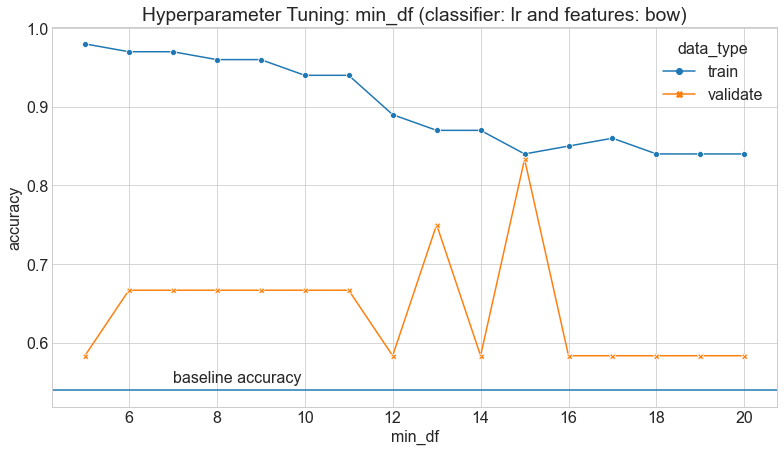

In [70]:
# Lineplot the accuracy against the min_df 

sns.lineplot(data=metrics_min_df, x='min_df', y='accuracy', hue='data_type', 
             style='data_type', markers=True, dashes=False)
plt.axhline(y=0.54)
plt.title("Hyperparameter Tuning: min_df (classifier: lr and features: bow)")
plt.text(7, 0.55, 'baseline accuracy')
plt.show()

In [54]:
feature_names14 = CountVectorizer(stop_words='english', 
                                 min_df=14, 
                                 ngram_range=(1,2), 
                                 binary=True).fit(train.clean).get_feature_names()

In [55]:
feature_names15 = CountVectorizer(stop_words='english', 
                                 min_df=15, 
                                 ngram_range=(1,2), 
                                 binary=True).fit(train.clean).get_feature_names()

In [56]:
set(feature_names14) - set(feature_names15)

{'available',
 'button',
 'click',
 'dependency',
 'end',
 'env',
 'git clone',
 'good',
 'package',
 'return',
 'step',
 'unit test',
 'way'}

**Takeaways**
1. Blue line represents the change of accuracy on train over the increase of the min_df while orange line represents the change of accuracy on validate.
2. The distance between the two lines is used as a measure for overfitting: the wider, the severe the overfitting. 
3. Suprisingly, when the min_df is 15, distance is the shortest, which indicates that the overfitting is minimized between and train and validate. 

### How does ngram_range affect the model performance?

In [57]:
# Loop through 

metrics_ngram = []
lr = LogisticRegression()

for i in range (2,6):
    vectorizer = CountVectorizer(stop_words='english', 
                                 min_df=15, 
                                 ngram_range=(1,i), 
                                 binary=True)
    print(vectorizer)
    vectorizer = vectorizer.fit(train.clean)
    X_train = vectorizer.transform(train.clean)
    X_validate = vectorizer.transform(validate.clean)
    lr = lr.fit(X_train, y_train)
    y_pred_train = lr.predict(X_train)
    y_pred_validate = lr.predict(X_validate)
    d1 = model.estimator_report(i, 'train', train.label, y_pred_train)
    metrics_ngram.append(d1)
    d2 = model.estimator_report(i, 'validate', validate.label, y_pred_validate)
    metrics_ngram.append(d2)

CountVectorizer(binary=True, min_df=15, ngram_range=(1, 2),
                stop_words='english')
CountVectorizer(binary=True, min_df=15, ngram_range=(1, 3),
                stop_words='english')
CountVectorizer(binary=True, min_df=15, ngram_range=(1, 4),
                stop_words='english')
CountVectorizer(binary=True, min_df=15, ngram_range=(1, 5),
                stop_words='english')


In [58]:
# Convert to dataframe
metrics_ngram = pd.DataFrame(metrics_ngram)

# Rename the columns
metrics_ngram.rename(columns={'model_type':'ngram_range'}, inplace=True)
metrics_ngram

,ngram_range,data_type,accuracy,precision,recall
0,2,train,0.840000,0.878788,0.707317
1,2,validate,0.833333,0.800000,0.800000
2,3,train,0.840000,0.878788,0.707317
3,3,validate,0.833333,0.800000,0.800000
4,4,train,0.840000,0.878788,0.707317
5,4,validate,0.833333,0.800000,0.800000
6,5,train,0.840000,0.878788,0.707317
7,5,validate,0.833333,0.800000,0.800000


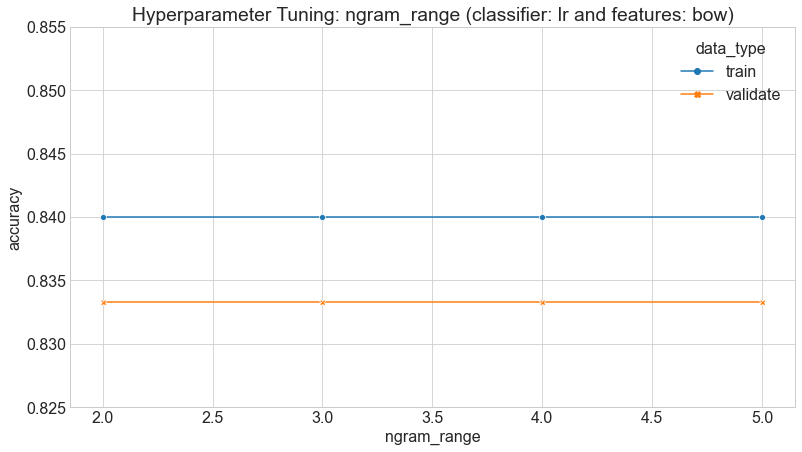

In [71]:
# Scatterplot the accuracy against the min_df 

sns.lineplot(data=metrics_ngram, x='ngram_range', y='accuracy', hue='data_type',
             style='data_type', markers=True, dashes=False)
plt.title("Hyperparameter Tuning: ngram_range (classifier: lr and features: bow)")
plt.ylim(0.825, 0.855)
plt.show()

**Takeaways**
1. Blue line represents the change of accuracy on train over the increase of the ngram_range while orange line represents the change of accuracy on validate.
2. The distance between the two lines is used as a measure for overfitting: the wider, the severe the overfitting. 
3. Suprisingly, the ngram_range has no effect on the model performance. 

### Modeling using KNN, Decision Tree and Random Forest

In [72]:
# Import libraries

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [127]:
# Create a list of names of the classifiers

names = ['LogisticRegression', 
         'Nearest Neighbors',
         'Decision Tree',
         'Random Forest',
        ]

In [128]:
# Create a list of classifiers

classifiers = [LogisticRegression(), 
               KNeighborsClassifier(3),
               DecisionTreeClassifier(max_depth=3),
               RandomForestClassifier(max_depth=3)
              ]

In [129]:
# The size between the two should be the same
len(names) == len(classifiers)

True

In [130]:
# Create an empty dataframe

metrics_clrs = pd.DataFrame()

for name, classifier in zip(names, classifiers):
    print(name)
    classifier = classifier.fit(X_train_bow, y_train)
    y_pred = classifier.predict(X_train_bow)
    d = model.estimator_report(name, 'train', y_train, y_pred)
    metrics_clrs = metrics_clrs.append(d, ignore_index=True)
    y_pred = classifier.predict(X_validate_bow)
    d = model.estimator_report(name, 'validate', y_validate, y_pred)
    metrics_clrs = metrics_clrs.append(d, ignore_index=True)

LogisticRegression
Nearest Neighbors
Decision Tree
Random Forest


In [131]:
metrics_clrs

,accuracy,data_type,model_type,precision,recall
0,0.840000,train,LogisticRegression,0.878788,0.707317
1,0.833333,validate,LogisticRegression,0.800000,0.800000
2,0.760000,train,Nearest Neighbors,0.840000,0.512195
3,0.500000,validate,Nearest Neighbors,0.333333,0.200000
4,0.720000,train,Decision Tree,1.000000,0.317073
5,0.583333,validate,Decision Tree,NaN,0.000000
6,0.800000,train,Random Forest,1.000000,0.512195
7,0.583333,validate,Random Forest,NaN,0.000000


### Modeling using Naive Bayes

In [132]:
# Create the naive bayes
gnb = GaussianNB()
gnb

GaussianNB()

In [133]:
metrics_gnb = pd.DataFrame()

# Fit on train.toarray features
gnb = gnb.fit(X_train_bowarray, y_train)

# Predict the 

y_pred = gnb.predict(X_train_bowarray)
d = model.estimator_report('NB', 'train', y_train, y_pred)
metrics_gnb = metrics_gnb.append(d, ignore_index=True)
y_pred = classifier.predict(X_validate_bowarray)
d = model.estimator_report('NB', 'validate', y_validate, y_pred)
metrics_gnb = metrics_gnb.append(d, ignore_index=True)

# Print the metrics
metrics_gnb

,accuracy,data_type,model_type,precision,recall
0,0.720000,train,NB,0.614035,0.853659
1,0.583333,validate,NB,NaN,0.000000


### How does the hyperparameter min_df affect the KNN performance

In [78]:
# Compute the accuary when min_df ranges from 5 to 21

metrics_knn = []
clr = KNeighborsClassifier(3)

for i in range (5, 21):
    vectorizer = CountVectorizer(stop_words='english', 
                                 min_df=i, 
                                 ngram_range=(1,2), 
                                 binary=True)
    vectorizer = vectorizer.fit(train.clean)
    X_train = vectorizer.transform(train.clean)
    X_validate = vectorizer.transform(validate.clean)
    clr = clr.fit(X_train, y_train)
    y_pred_train = clr.predict(X_train)
    y_pred_validate = clr.predict(X_validate)
    d1 = model.estimator_report(i, 'train', train.label, y_pred_train)
    metrics_knn.append(d1)
    d2 = model.estimator_report(i, 'validate', validate.label, y_pred_validate)
    metrics_knn.append(d2)

In [79]:
# Conver the metrics into dataframe
metrics_knn = pd.DataFrame(metrics_knn)

# Rename the columns
metrics_knn.rename(columns={'model_type':'min_df'}, inplace=True)
metrics_knn.head()

,min_df,data_type,accuracy,precision,recall
0,5,train,0.930000,0.947368,0.878049
1,5,validate,0.666667,0.571429,0.800000
2,6,train,0.930000,0.972222,0.853659
3,6,validate,0.666667,0.571429,0.800000
4,7,train,0.930000,1.000000,0.829268


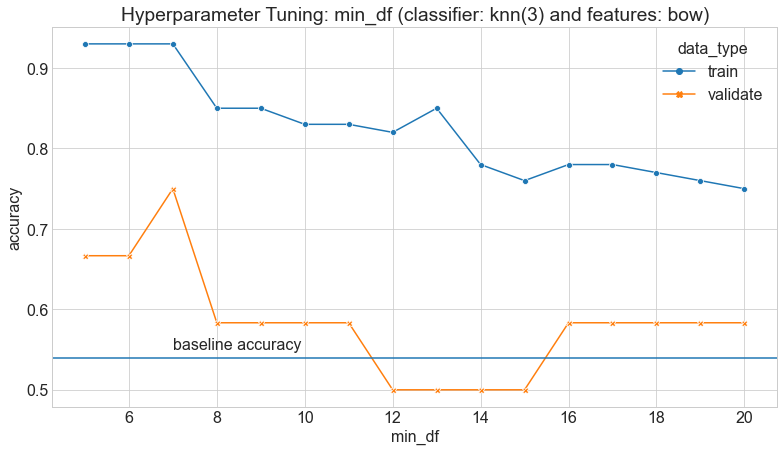

In [82]:
# Lineplot the accuracy against the min_df 

sns.lineplot(data=metrics_knn, x='min_df', y='accuracy', hue='data_type', 
             style='data_type', markers=True, dashes=False)
plt.axhline(y=0.54)
plt.title("Hyperparameter Tuning: min_df (classifier: knn(3) and features: bow)")
plt.text(7, 0.55, 'baseline accuracy')
plt.show()

### Model by Polynomial

In [83]:
def polyfeatures(X_train_scaled, y_train, X_validate_scaled, y_validate, n):
    pf = PolynomialFeatures(degree=n)
    pf = pf.fit(X_train_scaled)
    X_train_scaled = pf.transform(X_train_scaled)
    X_validate_scaled = pf.transform(X_validate_scaled)
    lr = LogisticRegression()
    lr = lr.fit(X_train_scaled, y_train)
    lr_pred = lr.predict(X_train_scaled)
    d1 = model.estimator_report(n, 'train', y_train, lr_pred)
    lr_pred = lr.predict(X_validate_scaled)
    d2 = model.estimator_report(n, 'validate', y_validate, lr_pred)
    return d1, d2

In [99]:
metrics_poly = []
degrees = [2,3]

for degree in degrees:
    d1, d2 = polyfeatures(X_train_bow, y_train, X_validate_bow, y_validate, degree)
    metrics_poly.append(d1)
    metrics_poly.append(d2)

In [100]:
# Conver the metrics into dataframe
metrics_poly = pd.DataFrame(metrics_poly)

In [101]:
metrics_poly

,model_type,data_type,accuracy,precision,recall
0,2,train,0.920000,0.971429,0.829268
1,2,validate,0.666667,0.666667,0.400000
2,3,train,0.920000,1.000000,0.804878
3,3,validate,0.666667,0.666667,0.400000


In [135]:
# Concat the metrics_clrs and metrics_poly

metrics_models = pd.concat([metrics_clrs, metrics_gnb, metrics_poly], ignore_index=True)
metrics_models

,accuracy,data_type,model_type,precision,recall
0,0.840000,train,LogisticRegression,0.878788,0.707317
1,0.833333,validate,LogisticRegression,0.800000,0.800000
2,0.760000,train,Nearest Neighbors,0.840000,0.512195
3,0.500000,validate,Nearest Neighbors,0.333333,0.200000
4,0.720000,train,Decision Tree,1.000000,0.317073
5,0.583333,validate,Decision Tree,NaN,0.000000
6,0.800000,train,Random Forest,1.000000,0.512195
7,0.583333,validate,Random Forest,NaN,0.000000
8,0.720000,train,NB,0.614035,0.853659
9,0.583333,validate,NB,NaN,0.000000


In [136]:
metrics_models.model_type = ['LR', 'LR', 'KNN', 'KNN', 'DT', 'DT', 'RF', 'RF', 
                             'NB', 'NB', 'Poly-2', 'Poly-2', 'Poly-3', 'Poly-3']

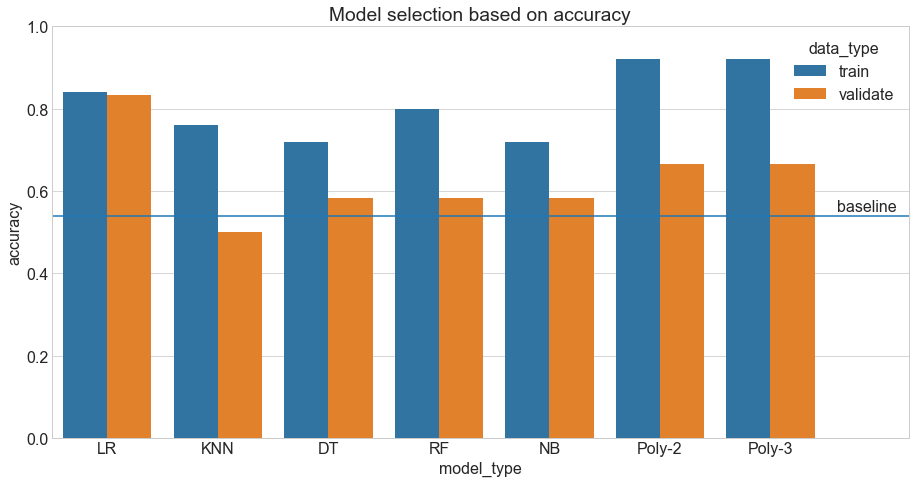

In [144]:
# Visualize the accuracy on train and validate modeled by different algorithms

sns.barplot(data=metrics_models, x='model_type', y='accuracy', hue='data_type')
plt.axhline(y=0.54)
plt.title("Model selection based on accuracy")
plt.text(6.6, 0.55, 'baseline')
plt.ylim(0, 1.0)
plt.xlim(-0.5, 7.25)
plt.tight_layout()
plt.show()

### Cross Validation

In [146]:
# Create the X and y for cross validation

X = df[['clean']]
y = df[['label']]

In [147]:
# Create the classifier for the cross validation

clr = LogisticRegression()
clr

LogisticRegression()

In [148]:
# Extract the features from the text

vectorizer = CountVectorizer(stop_words='english', 
                             min_df=15, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
X = vectorizer.fit_transform(df.clean)

In [150]:
# Compute the mean accuracy using cross validation
cross_val_score(clr, X, y, scoring='accuracy', cv=5).mean()

0.752